In [13]:
import numpy as np 
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression
import imutils
import sys
from skimage.feature import hog
from sklearn.externals import joblib
import cv2
from skimage import color
import matplotlib.pyplot as plt 
import os 
import glob
import warnings
warnings.filterwarnings('ignore')

In [14]:
detect_path = "dataset/detect"
winSize = (64, 128)
winStride = (4,4)
downscale = 1.17

In [15]:
#faster nms
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [16]:
def sliding_window(image, window_size, step_size):
    '''Returns a patch of the input 'image' of size 
       equal to 'window_size(64x128)'. Increments in
       x and y direction by 'step_size'.The function returns a tuple - (x, y, im_window)
    '''
    for y in range(0, image.shape[0]-128, step_size[1]):
        for x in range(0, image.shape[1]-64, step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

In [17]:
def detector(image):
    im = cv2.imread(image)
    im = imutils.resize(im, width = min(400, im.shape[1]))
    clf = joblib.load("person_final_hard.pkl")

    #List to store the detections
    detections = []
    #The current scale of the image 
    scale = 0
    #looping through images in a gaussian pyramid
    for im_scaled in pyramid_gaussian(im, downscale = downscale):
        #The list will store detections at the current scale
        #if the image dimension in gaussian pyramid goes below 64x128, break
        if im_scaled.shape[0] < winSize[1] or im_scaled.shape[1] < winSize[0]:
            break
        #at each scale in gaussian pyramid, image patch of 64x128 is extracted using sliding window
        for (x, y, im_window) in sliding_window(im_scaled, winSize, winStride):
            if im_window.shape[0] != winSize[1] or im_window.shape[1] != winSize[0]:
                continue
            im_window = color.rgb2gray(im_window)
            fd = hog(im_window,orientations=9,pixels_per_cell=(6,6),cells_per_block=(2,2),block_norm="L1",transform_sqrt=True)
            fd = fd.reshape(1, -1)
            pred = clf.predict(fd)
            #if it is a human
            if pred == 1:
                #and the probability is greater than 50 percent, count it as detection
                if clf.decision_function(fd) > 0.6:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), clf.decision_function(fd), 
                    int(winSize[0] * (downscale**scale)),
                    int(winSize[1] * (downscale**scale))))
            
                 

        scale += 1

    clone = im.copy()
    #drawing original boxes
    for (x_tl, y_tl, _, w, h) in detections:
        cv2.rectangle(clone, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 255, 0), thickness = 2)

    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
    sc = [score[0] for (x, y, score, w, h) in detections]
    print ("sc: ", sc)
    sc = np.array(sc)
    pick = non_max_suppression_fast(rects, overlapThresh = 0.27)
    print ("shape, ", pick.shape)
    #final bounding boxes
    for(xA, yA, xB, yB) in pick:
        cv2.rectangle(im, (xA, yA), (xB, yB), (0, 255, 0), 2)
    plt.figure(1)
    plt.title("Detections")
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()

Progress 12.819905213270141sc:  [0.6024297790418276, 0.6735379045640161, 0.8601978140868607, 0.9953838655264198, 0.7449830535992255, 0.6095511021167828, 0.6296993311346195, 0.7590103892058485, 0.8039277209771372, 0.6679114484702318, 0.7285053226260075, 0.6208800869565883, 0.7660497052223634, 1.006881145723902, 0.9402389977105472, 0.8534387591937855, 0.7409471024588912, 0.6870101523189867, 0.8606947135598155, 0.9338780982619361, 0.8414288215775179, 0.6548493191456316, 0.7645002416293141, 0.6102606692696342, 0.8946020014382685, 0.8120714749176154, 0.6291086790134319, 0.7674219230376568, 0.7742948918807879, 0.6543520802685601, 0.6387598374188167, 0.6218995995950061, 0.6186535166563375, 0.6072832898001848, 0.6629449983122239, 0.8140651784288304, 0.7123000663910718, 0.9044018288309881, 0.8351944839243746, 0.6690096503838281, 0.7642230791703921, 0.713592026039449, 0.7650037554627451, 0.6589641092565074, 0.6468763201392835, 0.6706719706815402, 0.7540667568973378, 0.6926810023131773, 0.7308159

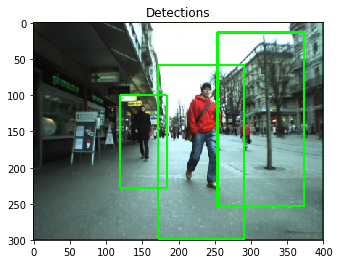

In [18]:
filenames = glob.iglob(os.path.join(detect_path, '*'))

for file in filenames:
    detector(file)